# European Restaurant Reviews

# Imports

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


# Functions

In [103]:

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def check_nulls_dupes(df):
  print(f"The Amount of Nulls: {df.isna().sum()}")
  print(f"The Amount of Dupes: {df.duplicated().sum()}")

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Aggregate of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="stratified")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_kbest_columns(X, y, sample_model, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)


# EDA Analysis

In [70]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...
...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Oct 2016 •,Despite the other reviews saying that this is ...
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,Oct 2016 •,beer is good. food is awfull The only decent...
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,Oct 2016 •,"for terrible service of a truly comedic level,..."
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,Oct 2016 •,We visited the Havana's Club Museum which is l...


# Check For Nulls and Dupes

In [71]:
check_nulls_dupes(df)

The Amount of Nulls: Country            0
Restaurant Name    0
Sentiment          0
Review Title       0
Review Date        0
Review             0
dtype: int64
The Amount of Dupes: 49


In [72]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

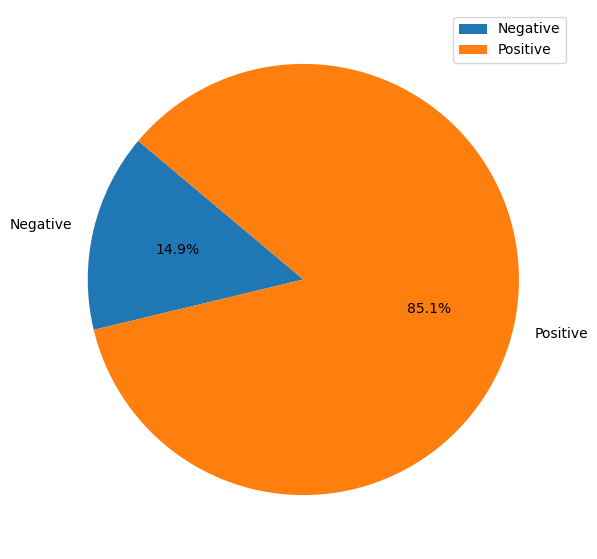

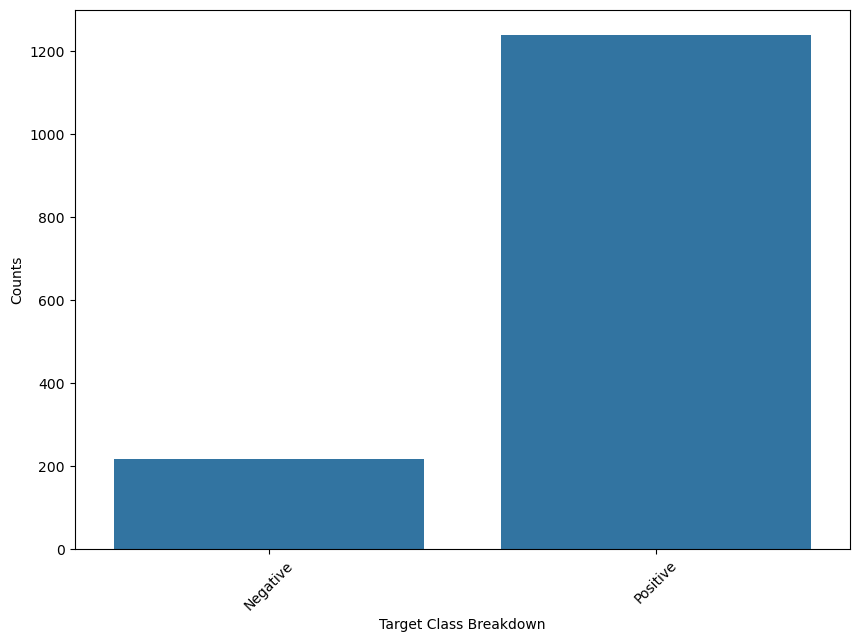

In [73]:
check_class_imbalance(df["Sentiment"])

# Severe Class Imbalance Exists

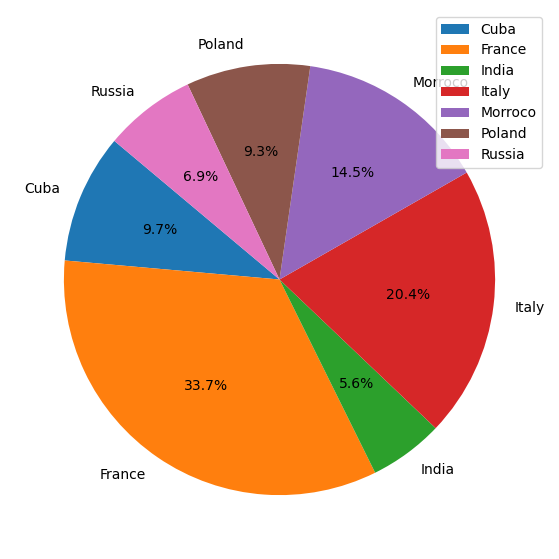

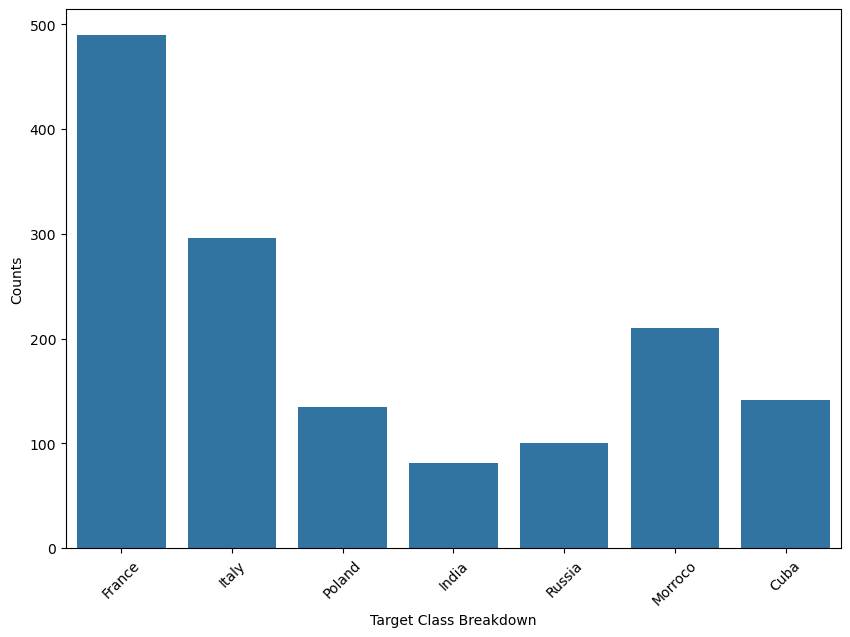

In [74]:
check_class_imbalance(df["Country"])

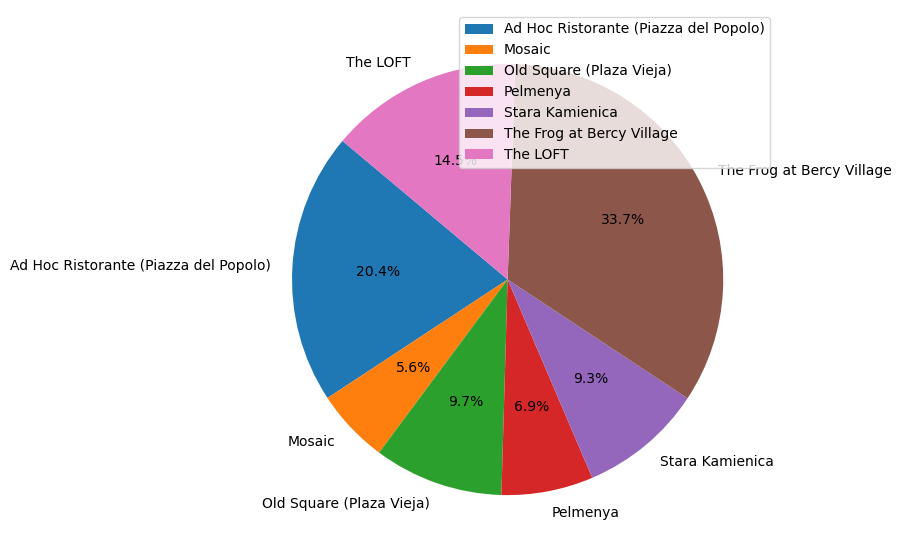

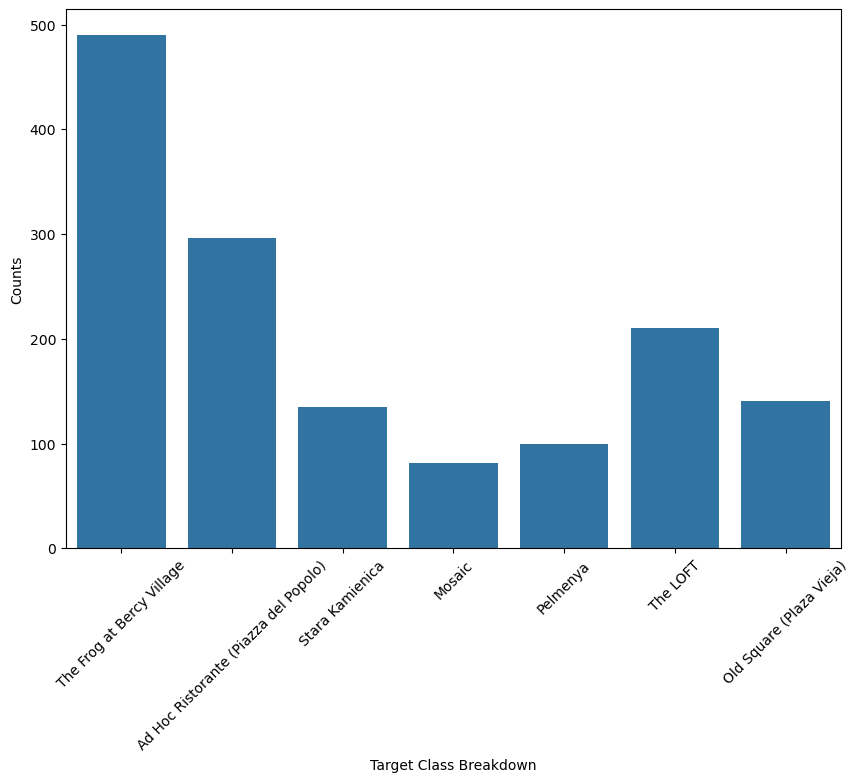

In [75]:
check_class_imbalance(df["Restaurant Name"])

In [76]:
df.drop(["Review Title", "Review Date"], inplace=True, axis=1)

# Label Encode Sentiment Column

In [77]:
df["new_sentiment"] = df["Sentiment"].apply(lambda x: 0 if  x == "Negative" else 1)

# Positive Sentiment DF Analysis

In [78]:
positive_sentiment = df[df["Sentiment"] == "Positive"]

# Breakdown Of Positive Reviews by restaurant

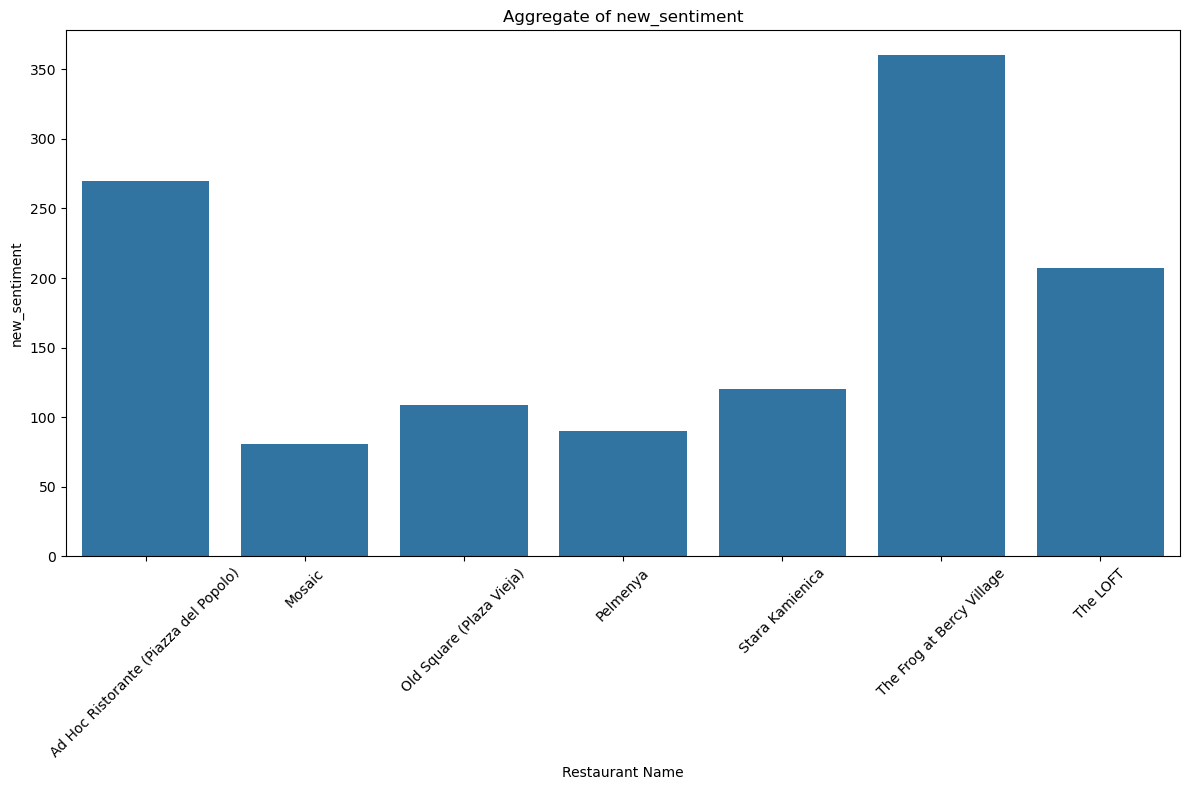

In [79]:
aggregate_dataset(positive_sentiment, ["new_sentiment"], "Restaurant Name", "sum")

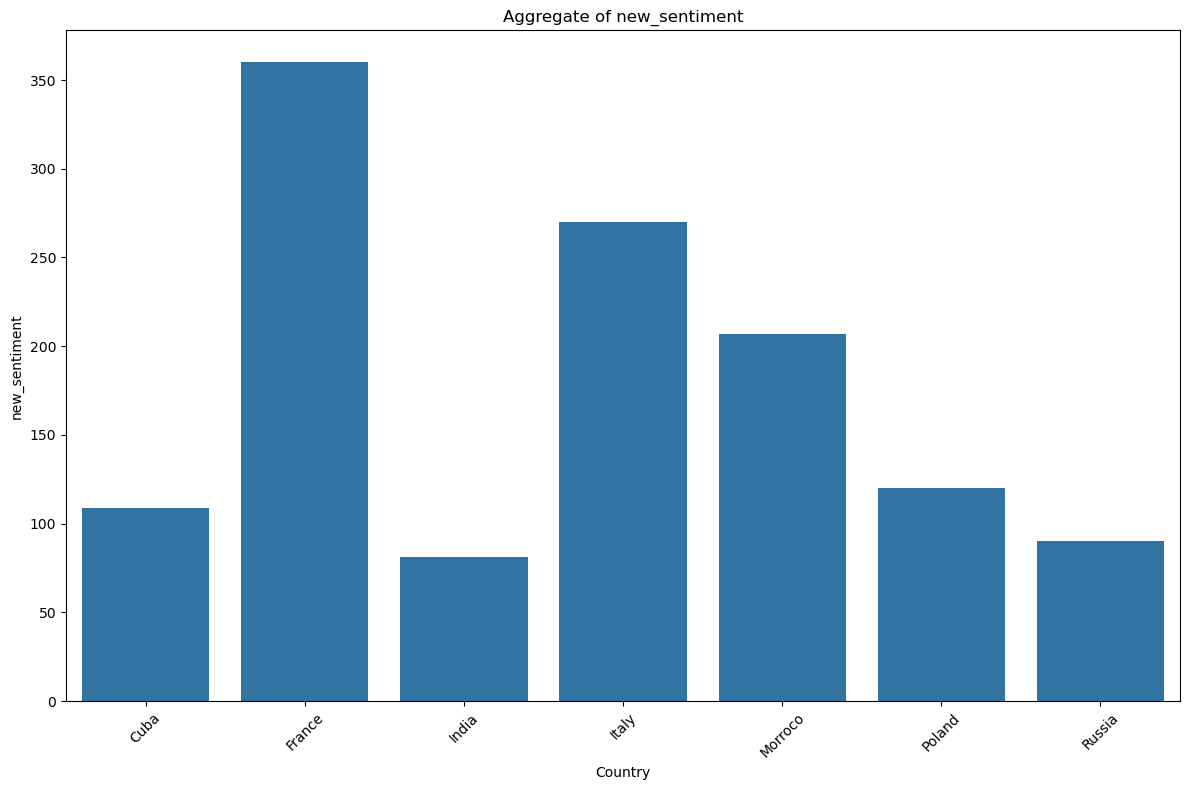

In [80]:
aggregate_dataset(positive_sentiment, ["new_sentiment"], "Country", "sum")

# Apparently France and Italy get the most positive reviews

# Negative Reviews

In [81]:
negative_sentiment = df[df["Sentiment"] != "Positive"]
negative_sentiment["new_sentiment"] = negative_sentiment["new_sentiment"].apply(lambda x: x+1)

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_6582/1521979315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_sentiment["new_sentiment"] = negative_sentiment["new_sentiment"].apply(lambda x: x+1)


# Most Negative Reviews

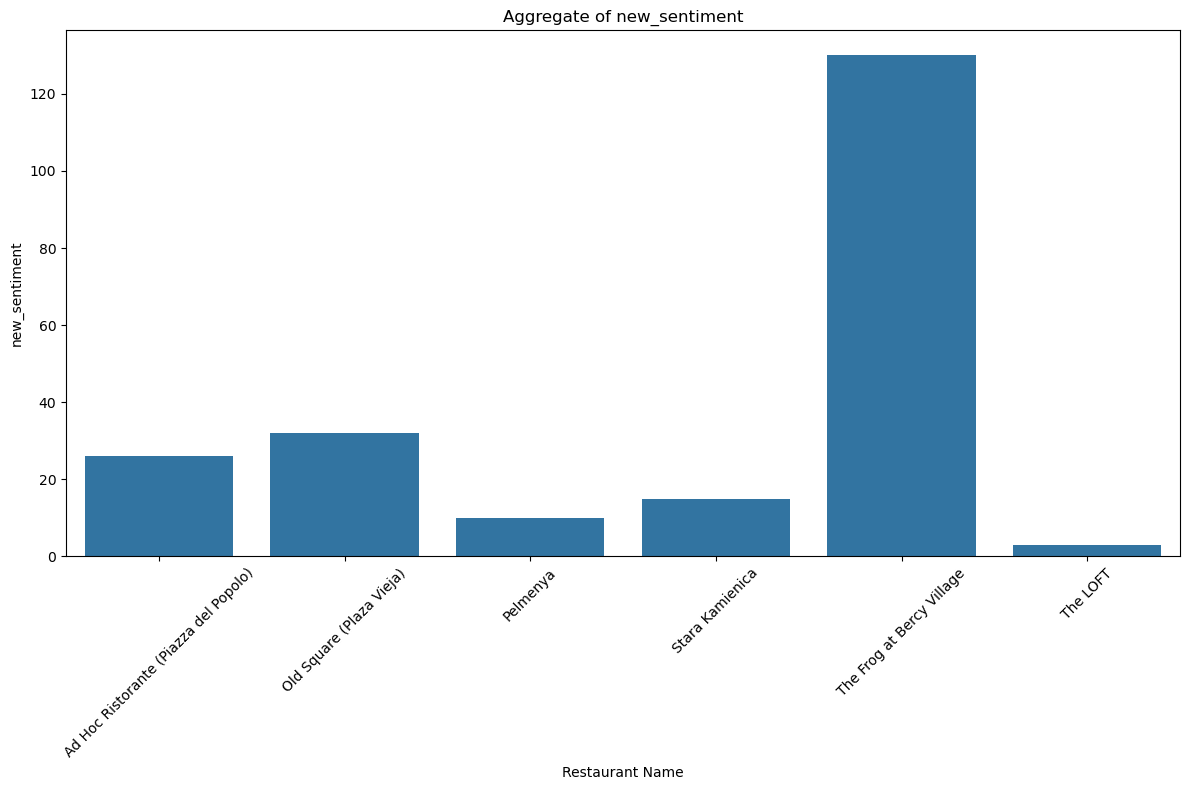

In [82]:
aggregate_dataset(negative_sentiment, ["new_sentiment"], "Restaurant Name", "sum")

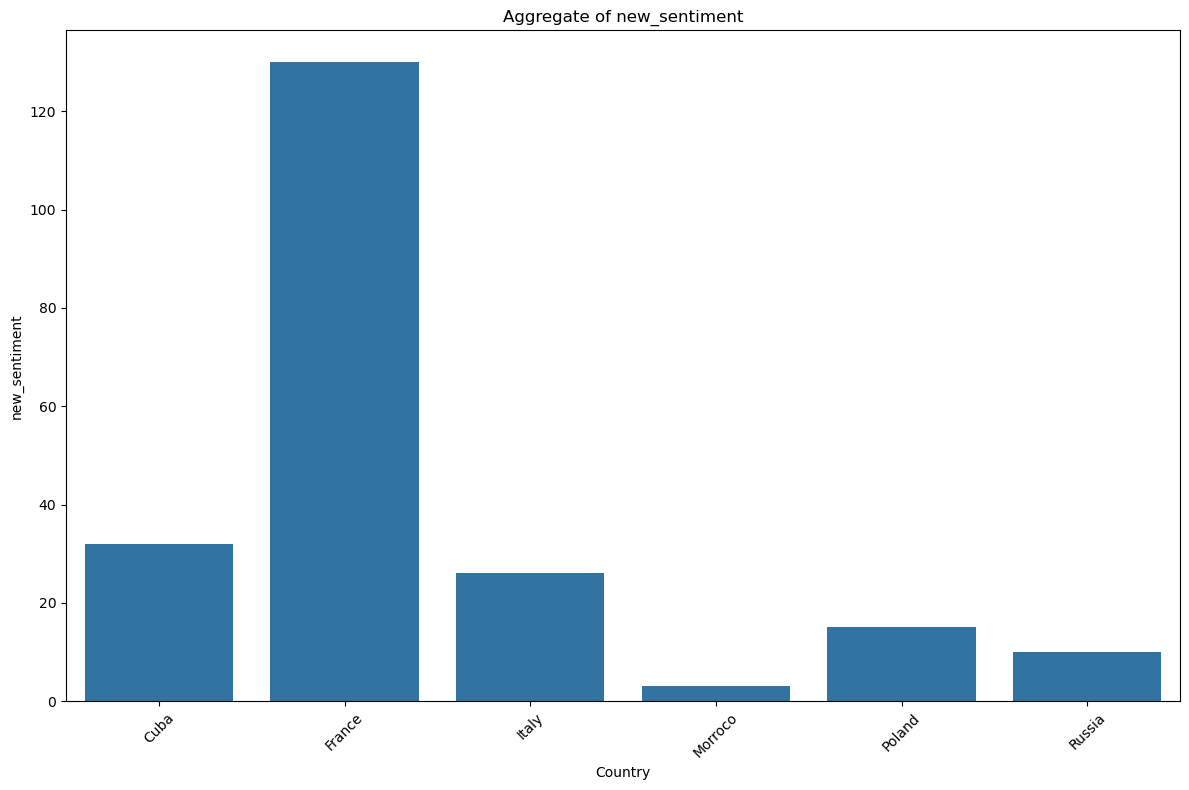

In [83]:
aggregate_dataset(negative_sentiment, ["new_sentiment"], "Country", "sum")

# France has the most positive reviews but also has the most negative reviews. This might be because France has the most observations from the dataset.

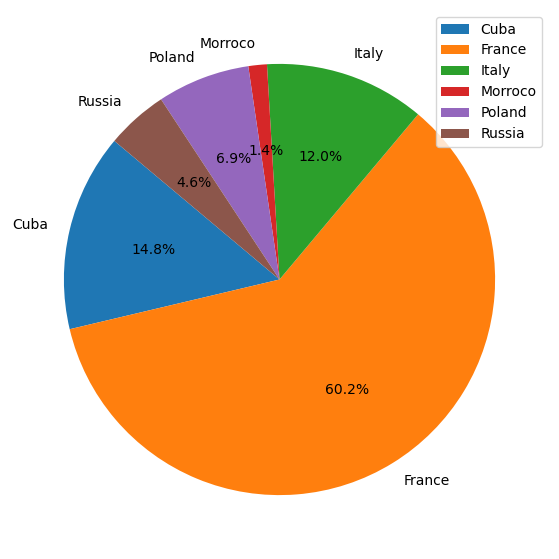

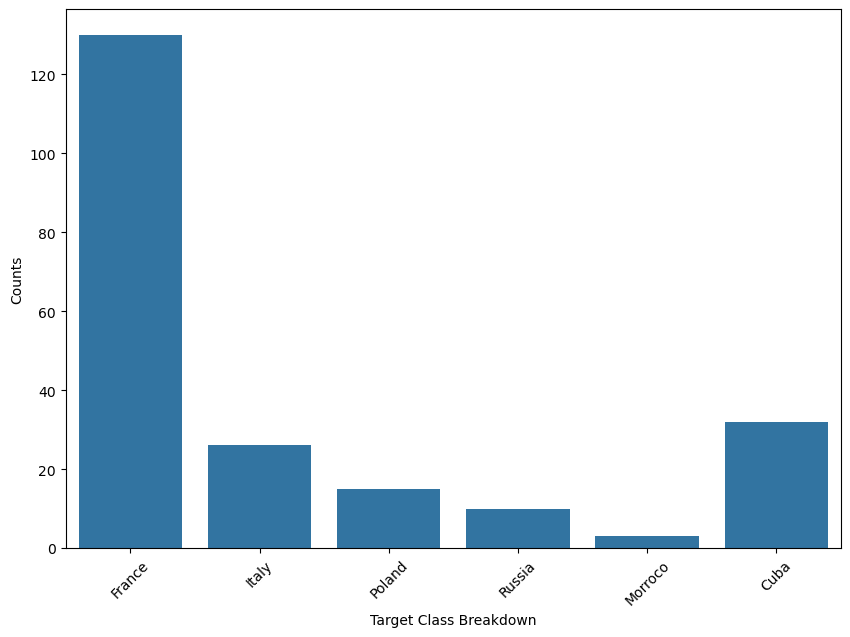

In [84]:
check_class_imbalance(negative_sentiment["Country"])

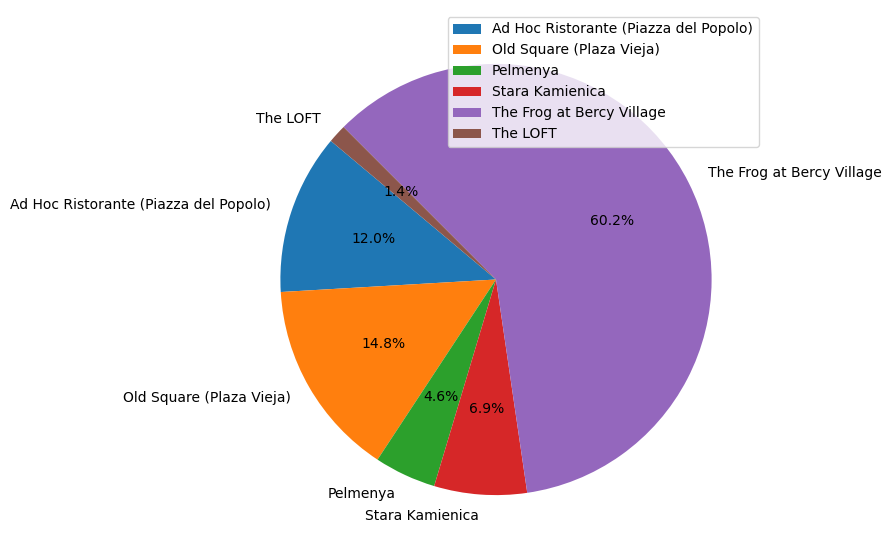

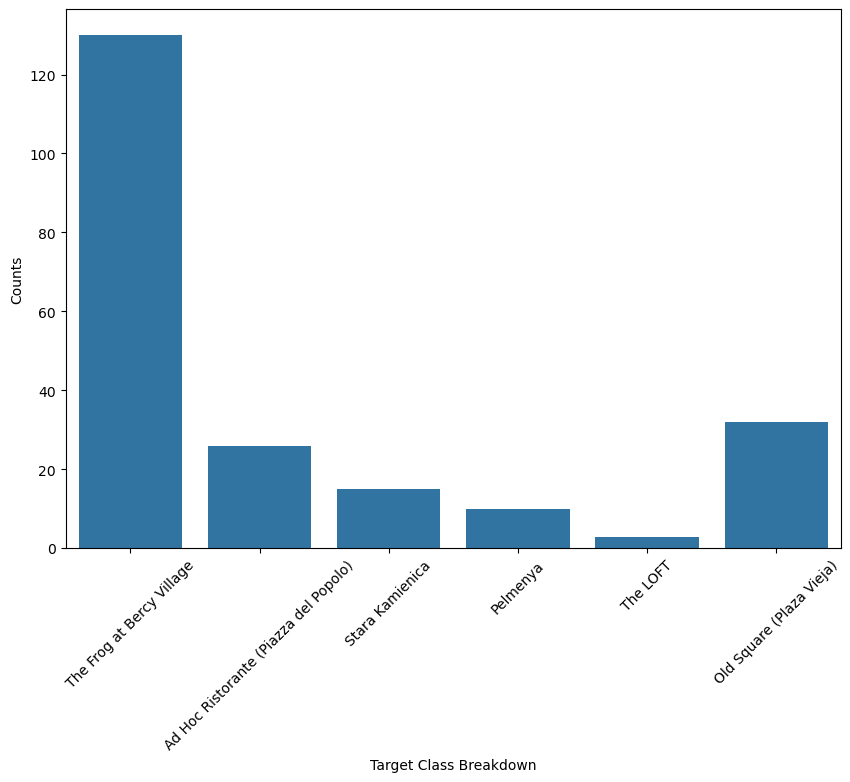

In [85]:
check_class_imbalance(negative_sentiment["Restaurant Name"])

In [86]:
hot_encoder = OneHotEncoder()
encoder = LabelEncoder()
tfidf_vectorizer = TfidfVectorizer()

# Separate Variables 

In [87]:
X = df.drop(["Sentiment"], axis=1)
y = df["Sentiment"]

In [88]:
y_encoded = encoder.fit_transform(y)

In [89]:
encoder = OneHotEncoder(sparse=True)
categorical_features = ['Country', 'Restaurant Name']
encoded_data = encoder.fit_transform(X[categorical_features])

X = pd.concat([X.drop(categorical_features, axis=1).reset_index(drop=True), 
               pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_features))], axis=1)


tfidf_matrix = tfidf_vectorizer.fit_transform(X['Review'])
X = pd.concat([X.drop(['Review'], axis=1).reset_index(drop=True), 
               pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())], axis=1)


In [90]:
X.shape

(1453, 6285)

In [91]:
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [96]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [97]:
X_pca.shape

(1453, 1076)

# Create Metrics

In [105]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')